In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import tree
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

# Category as a predictive attribute

In [2]:
usData = pd.read_csv('../Data/YouTube/cleaned_us.csv')
usData['trending_date'] = '20' + usData['trending_date']
usData['trending_date'] = pd.to_datetime(usData['trending_date'],format='%Y.%d.%m')

In [3]:
usData.head(5)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13T17:13:01.000Z,shantell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21T06:47:32.000Z,"cute,cats,thai,eggs",98966,2486,184,532,https://i.ytimg.com/vi/0mlNzVSJrT0/default.jpg,False,False,False,Kittens come out of the eggs in a Thai commerc...,People & Blogs
2,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11T15:00:03.000Z,"shawn johnson,andrew east,shawn east,shawn and...",321053,4451,1772,895,https://i.ytimg.com/vi/STI2fI7sKMo/default.jpg,False,False,False,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs
3,KODzih-pYlU,2017-11-14,BLIND(folded) CAKE DECORATING CONTEST (with Mo...,Grace Helbig,2017-11-11T18:08:04.000Z,"itsgrace,funny,comedy,vlog,grace,helbig,graceh...",197062,7250,217,456,https://i.ytimg.com/vi/KODzih-pYlU/default.jpg,False,False,False,Molly is an god damn amazing human and she cha...,People & Blogs
4,8mhTWqWlQzU,2017-11-14,Wearing Online Dollar Store Makeup For A Week,Safiya Nygaard,2017-11-11T01:19:33.000Z,"wearing online dollar store makeup for a week,...",2744430,115426,1110,6541,https://i.ytimg.com/vi/8mhTWqWlQzU/default.jpg,False,False,False,I found this online dollar store called ShopMi...,People & Blogs


### Categories vs. Views

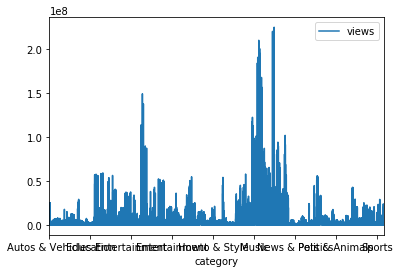

In [4]:
usData.sort_values('category').plot.line(x='category',y='views')

In [5]:
#From the plot above we can see that there are clearly categories that generally produce trending videos with more views

In [6]:
usData.sort_values('views', ascending=False).head(10)['category']

31861    Music
31815    Music
31772    Music
31729    Music
31684    Music
31644    Music
31606    Music
31564    Music
31519    Music
31478    Music
Name: category, dtype: object

In [7]:
# We can see that for the trending videos with the most views - the top 10 come from The music category
# This would likely be because music videos are likley to be watch more than once and other videos like blogs will probably only
# be viewed once.

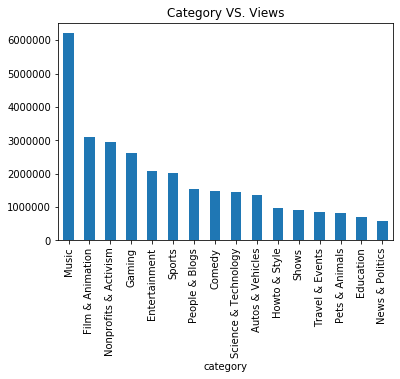

In [8]:
ax = usData.groupby('category')['views'].mean().sort_values(ascending=False).plot.bar()
ax.set_title("Category VS. Views")
plt.show()

In [9]:
#We can see here from a graph of the average video views that the music category still dominates the types of videos in trending

### Categories vs. comments

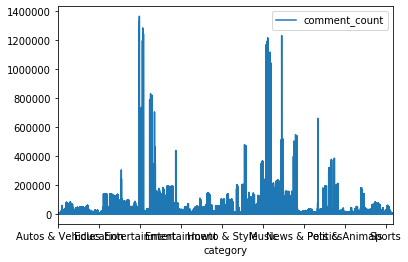

In [10]:
usData.sort_values('category').plot.line(x='category',y='comment_count')

In [11]:
# looking at the categories vs. comment count we can see that several types of videos get more comments than others

In [12]:
usData.sort_values('comment_count', ascending=False).head(10)[['category','comment_count']]

,category,comment_count
5910,Entertainment,1361580
5858,Entertainment,1321281
5812,Entertainment,1281094
5724,Entertainment,1238817
31798,Music,1228655
31755,Music,1225326
31713,Music,1213172
31668,Music,1204867
31628,Music,1197130
5770,Entertainment,1194249


In [13]:
# the top 4 videos with comments are all enternainment videos, with then music folling closely behind

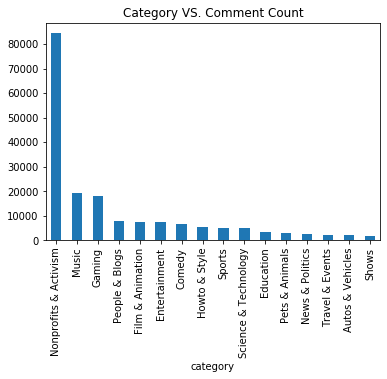

In [14]:
ax = usData.groupby('category')['comment_count'].mean().sort_values(ascending=False).plot.bar()
ax.set_title("Category VS. Comment Count")
plt.show()

In [15]:
# A different stroy can be seen if we look at the average number of comments on trending videos of a certain category. The
# Nonprofit and activism category has the most average comments while the entertainment section drops down to 6th place.

# This is insteresting as it tells a very different story than the categories vs. views the veiws are more consistent per
# category, but the comments seem to vary

### Most trending videos by category over time

In [16]:
usData['trending_month'] = pd.DatetimeIndex(usData['trending_date']).month

In [17]:
usData['trending_year'] = pd.DatetimeIndex(usData['trending_date']).year

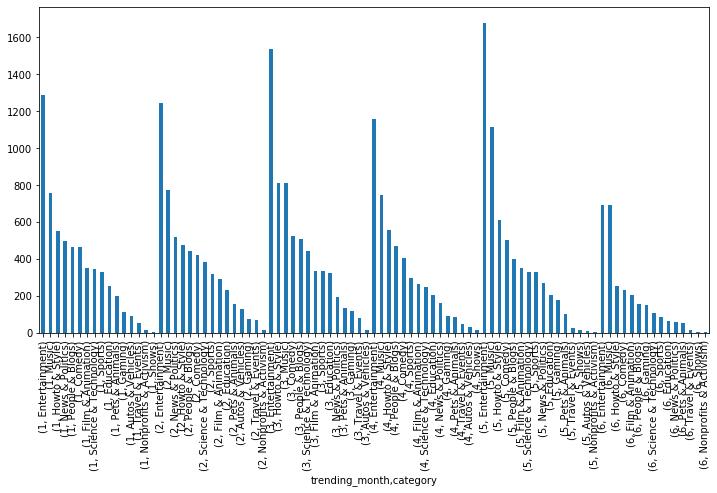

In [18]:
plt.figure(figsize=(12, 6))
usData.groupby(['trending_year','trending_month'])['category'].value_counts()[2018].plot.bar()

### Decision tree to predict what category a video is in

In [19]:
usData['category'].astype('category')
usData.head(1)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category,trending_month,trending_year
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13T17:13:01.000Z,shantell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,11,2017


In [20]:
attributes = usData[['views','likes','dislikes','comment_count']]
target = usData['category'].astype('category')

In [21]:
usData['category'].value_counts().index

Index(['Entertainment', 'Music', 'Howto & Style', 'Comedy', 'People & Blogs',
       'News & Politics', 'Science & Technology', 'Film & Animation', 'Sports',
       'Education', 'Pets & Animals', 'Gaming', 'Travel & Events',
       'Autos & Vehicles', 'Nonprofits & Activism', 'Shows'],
      dtype='object')

In [22]:
usData['category'].value_counts()

Entertainment            9944
Music                    6467
Howto & Style            4142
Comedy                   3453
People & Blogs           3208
News & Politics          2485
Science & Technology     2397
Film & Animation         2343
Sports                   2172
Education                1655
Pets & Animals            920
Gaming                    816
Travel & Events           401
Autos & Vehicles          384
Nonprofits & Activism      57
Shows                      57
Name: category, dtype: int64

In [23]:
Tree = tree.DecisionTreeClassifier()
parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}
TreeCV = GridSearchCV(Tree,param_grid=parameters, return_train_score=True)
TreeCV.fit(attributes,target)
TreeCV.best_params_

C:\Users\bathtj\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 7}

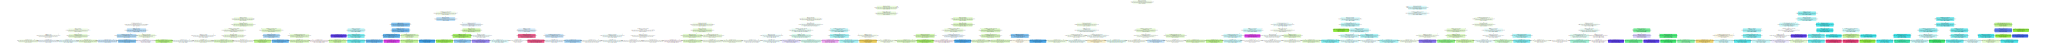

In [24]:
Tree = tree.DecisionTreeClassifier(max_depth=7)
Tree.fit(attributes,target)
# display the tree
dot_data = tree.export_graphviz(Tree,
                              out_file=None,
                              feature_names=attributes.columns,
                              class_names=usData['category'].value_counts().index,
                              proportion=True,
                              impurity=False,
                              filled=True,
                              rounded=True)
graph = graphviz.Source(dot_data)
graph.render('CatgegoryOFTrendingVideo')
graph

In [25]:
#Jimmy Fallon - Comedy
test = pd.DataFrame()
test['views'] = [3224141]
test['likes'] = [98805]
test['dislikes'] = [3560]
test['comment_count'] = [2455]
Tree.predict(test)

array(['Music'], dtype=object)

In [26]:
#Star Wars the clone wars trailer - Entertainment
test = pd.DataFrame()
test['views'] = [3586334]
test['likes'] = [221592]
test['dislikes'] = [3256]
test['comment_count'] = [8032]
Tree.predict(test)

array(['Music'], dtype=object)

In [27]:
#GMM - Entertainment
test = pd.DataFrame()
test['views'] = [152912]
test['likes'] = [6649]
test['dislikes'] = [108]
test['comment_count'] = [454]
Tree.predict(test)

array(['Howto & Style'], dtype=object)

In [28]:
#U.S. Senate Impeachment Trial - News and politics
test = pd.DataFrame()
test['views'] = [425679]
test['likes'] = [4253]
test['dislikes'] = [1389]
test['comment_count'] = [967]
Tree.predict(test)

array(['Sports'], dtype=object)

In [29]:
(1 - Tree.score(attributes,target)).round(2)

0.65

### Naive Bayes classifier to predict category of video

In [30]:
NBayes = MultinomialNB()
NBayes.fit(attributes,target)
(1 - NBayes.score(attributes,target)).round(2)

0.88

In [31]:
#not very good predictions from either a decision tree or from using naive bayes classifiers.

In [32]:
labels = target.cat.categories
predict = NBayes.predict(attributes)
ConfMat = confusion_matrix(target,predict)
ConfMat = pd.DataFrame(ConfMat,index=labels,columns=labels)
ConfMat

,Autos & Vehicles,Comedy,Education,Entertainment,Film & Animation,Gaming,Howto & Style,Music,News & Politics,Nonprofits & Activism,People & Blogs,Pets & Animals,Science & Technology,Shows,Sports,Travel & Events
Autos & Vehicles,164,18,5,12,2,17,13,20,10,0,0,15,60,11,3,34
Comedy,300,1078,70,164,81,71,144,417,74,309,94,52,22,227,67,283
Education,74,305,184,59,30,70,166,303,38,39,41,171,70,26,28,51
Entertainment,1816,1200,341,444,408,512,389,724,738,287,125,492,280,870,317,1001
Film & Animation,527,231,60,108,114,103,128,198,116,59,46,152,49,187,62,203
Gaming,26,129,23,41,11,197,125,43,11,44,4,45,33,24,25,35
Howto & Style,120,1467,360,112,150,85,390,527,48,252,104,142,35,129,96,125
Music,314,2186,224,201,233,167,100,1007,69,534,94,140,41,601,212,344
News & Politics,812,61,4,36,38,255,8,38,831,65,15,39,44,35,44,160
Nonprofits & Activism,13,8,0,0,0,0,2,12,7,9,3,0,0,0,0,3


In [33]:
# from the confusion matrix seen here you can see that the number of views,likes,and dislikes does nto likely give a very good
# insight into what category a video is. This is suggests that videos that trend can really come from anywhere as the 
# decision tree and naive bayes classifier gave very high error rates.

### K-Means clustering of categories

In [47]:
usData['category'].value_counts()

Entertainment            9944
Music                    6467
Howto & Style            4142
Comedy                   3453
People & Blogs           3208
News & Politics          2485
Science & Technology     2397
Film & Animation         2343
Sports                   2172
Education                1655
Pets & Animals            920
Gaming                    816
Travel & Events           401
Autos & Vehicles          384
Nonprofits & Activism      57
Shows                      57
Name: category, dtype: int64

In [48]:
km = KMeans(n_clusters=16,n_init=300)
km.fit(attributes)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=300, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [49]:
lables = km.predict(attributes)
lables

array([0, 0, 0, ..., 9, 9, 9])

#### Views vs. Likes

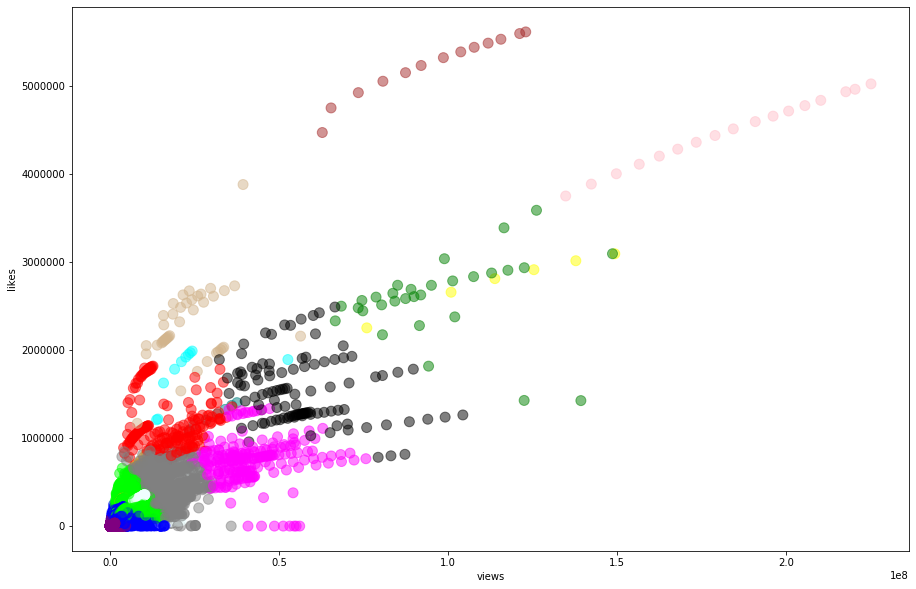

In [65]:
#k-means clustering 
df = pd.DataFrame()
color = np.array(['blue','green','yellow','red','orange',
                  'purple','cyan','brown','pink','black',
                  'tan','gray','fuchsia','lime','azure','teal'])
df['kmeans'] = color[lables]
usData.plot.scatter(x='views',y='likes',c=df.kmeans, s=100,alpha=0.5,figsize=(15,10))

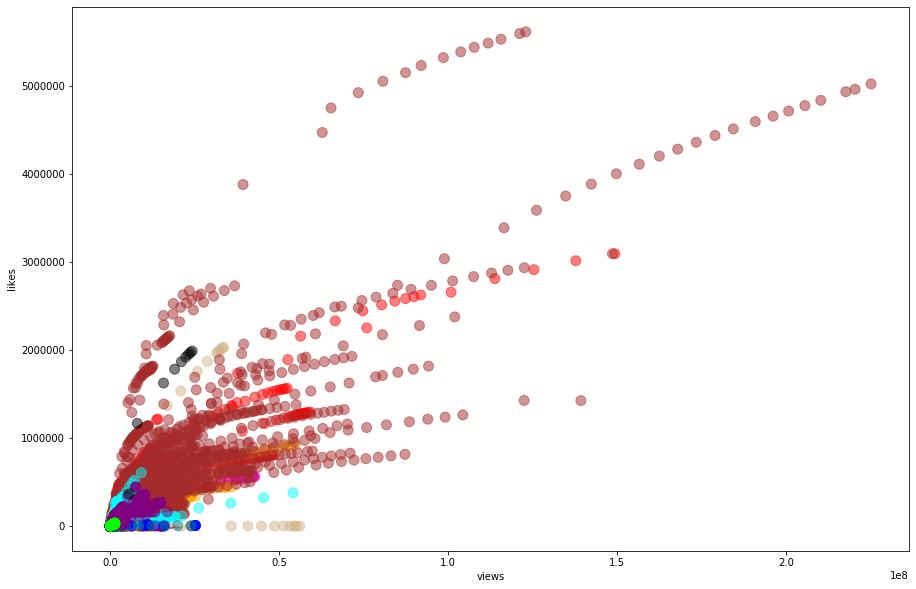

In [66]:
# scatter plot of actual categories
usData['category'] = usData['category'].astype('category')
df['categories'] = color[usData.category.cat.codes.values]
usData.plot.scatter(x='views',y='likes',c=df.categories, s=100,alpha=0.5,figsize=(15,10))

In [67]:
#standardize the attributes for a k-means plot
attributes=(attributes-attributes.mean())/attributes.std()
km = KMeans(n_clusters=16,n_init=300)
km.fit(attributes)
lables = km.predict(attributes)
lables

array([0, 6, 6, ..., 6, 6, 6])

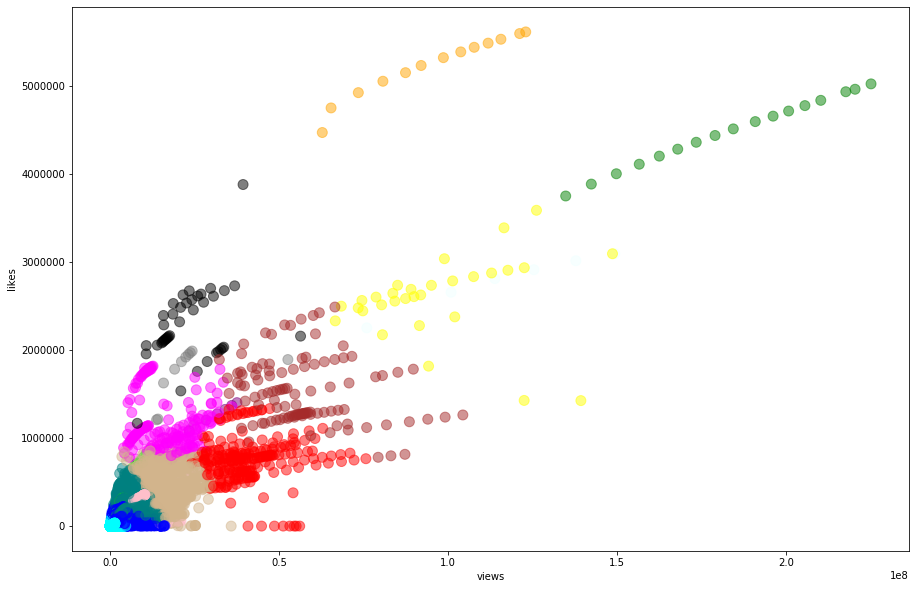

In [68]:
df = pd.DataFrame()
color = np.array(['blue','green','yellow','red','orange',
                  'purple','cyan','brown','pink','black',
                  'tan','gray','fuchsia','lime','azure','teal'])
df['kmeans'] = color[lables]
usData.plot.scatter(x='views',y='likes',c=df.kmeans, s=100,alpha=0.5,figsize=(15,10))

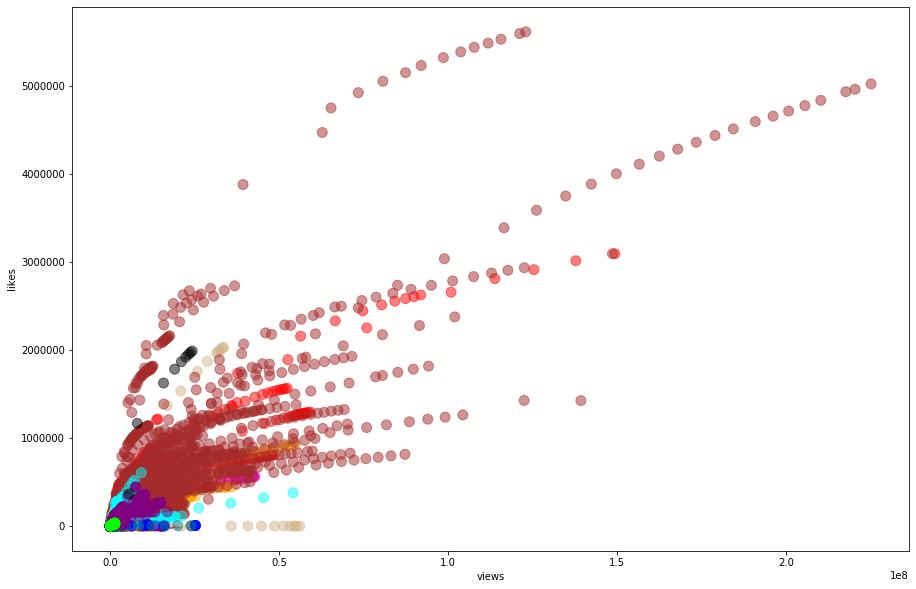

In [69]:
usData['category'] = usData['category'].astype('category')
df['categories'] = color[usData.category.cat.codes.values]
usData.plot.scatter(x='views',y='likes',c=df.categories, s=100,alpha=0.5,figsize=(15,10))

In [72]:

# from the clustering on the data sets we can see that there is not great clustering for the data points around the categories

# there does appear to be some correlation in the groupings but some are actual 1 larger cluster and so there woulkd be
# many missed predictions.

#### Likes vs. Dislikes

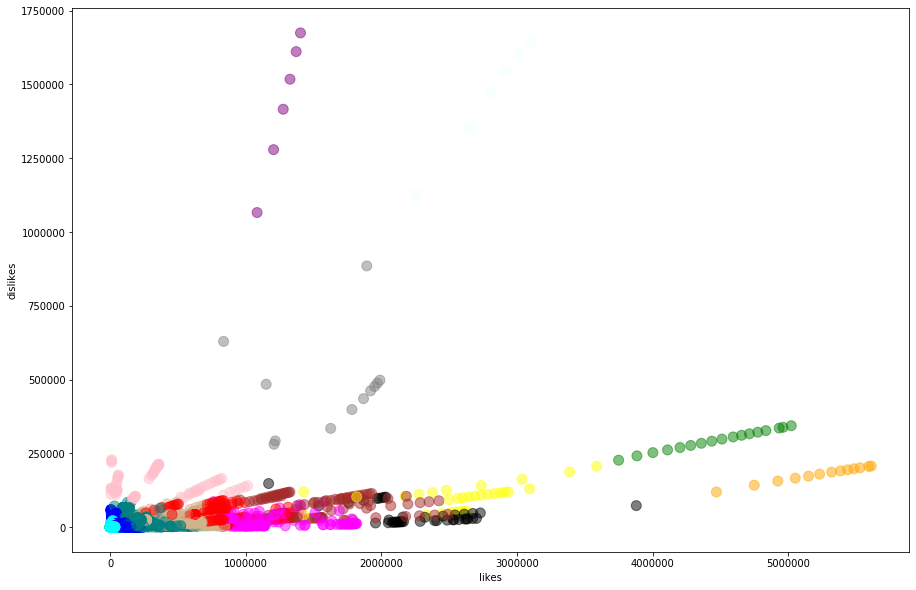

In [73]:
# standardized attributes k-means scatter plot of likes vs dislikes
df = pd.DataFrame()
color = np.array(['blue','green','yellow','red','orange',
                  'purple','cyan','brown','pink','black',
                  'tan','gray','fuchsia','lime','azure','teal'])
df['kmeans'] = color[lables]
usData.plot.scatter(x='likes',y='dislikes',c=df.kmeans, s=100,alpha=0.5,figsize=(15,10))

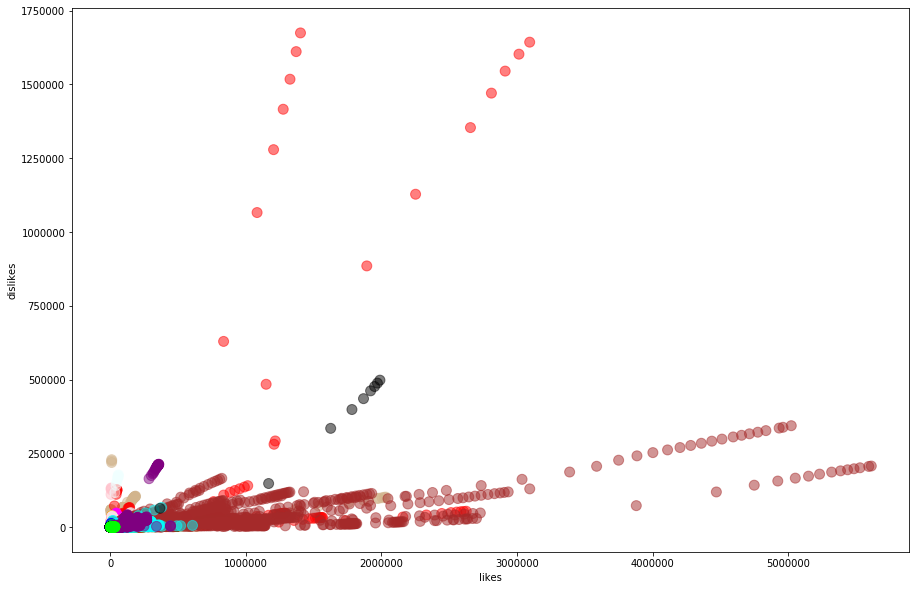

In [74]:
# actual categories likes vs dislikes
usData['category'] = usData['category'].astype('category')
df['categories'] = color[usData.category.cat.codes.values]
usData.plot.scatter(x='likes',y='dislikes',c=df.categories, s=100,alpha=0.5,figsize=(15,10))

In [75]:
# we can see the same type of misprediction here in this scatter plot for likes vs. dislikes. There are some categories made
# that actually contain mostly another categories videos

# Video Title Length

## US

In [34]:
VideoTitleLengthUS = pd.DataFrame()
#VideoTitleLength['title'] = usData['title']
VideoTitleLengthUS['views'] = usData['views']
VideoTitleLengthUS['length'] = usData['title'].str.len()
VideoTitleLengthUS.head(3)

,views,length
0,748374,34
1,98966,20
2,321053,75


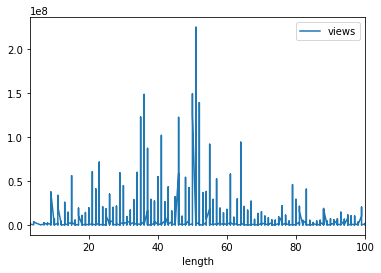

In [35]:
VideoTitleLengthUS.sort_values('length').plot.line(x='length',y='views')

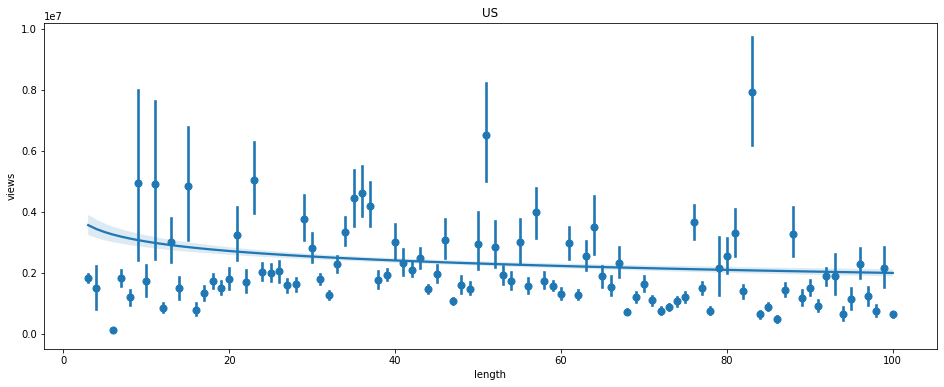

In [36]:
plt.figure(figsize=(16, 6))
ax = sns.regplot(x="length", y="views", data=VideoTitleLengthUS, x_estimator=np.mean, logx=True, truncate=True)
ax.set_title('US')
plt.show()

In [37]:
# we can see from the above regression curve that the lenght of the video title does not tend to affect the views, although
# there is a slight uptick in the number of views with short video titles.

# this could suggest that if people can see the information about a video in a short glance they may be more likely to watch
# which would help the video to trend.

## Great Britain

In [38]:
gbData = pd.read_csv('../Data/YouTube/cleaned_gb.csv')
gbData.head(3)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,2017-11-10T07:38:29.000Z,"christmas,john lewis christmas,john lewis,chri...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,Howto & Style
1,MyEqfBkzESU,17.14.11,EXTREME GOLDEN TAN TRANSFORMATION,John Maclean,2017-11-10T20:40:44.000Z,"extreme tan,tanning,tanning bed,how to get bes...",300617,8133,2693,2911,https://i.ytimg.com/vi/MyEqfBkzESU/default.jpg,False,False,False,-\n\n\nWebsite - http://www.johnmaclean.co.uk\...,Howto & Style
2,b4vTZx_AtHk,17.14.11,How To Dry a Shirt in 30 Seconds,HowToBasic,2017-11-09T18:36:48.000Z,"how to dry a shirt in 30 seconds,how to dry a ...",2063667,98804,11682,11443,https://i.ytimg.com/vi/b4vTZx_AtHk/default.jpg,False,False,False,Today I show you how to completely dry a shirt...,Howto & Style


In [39]:
VideoTitleLengthGB = pd.DataFrame()
VideoTitleLengthGB['views'] = gbData['views']
VideoTitleLengthGB['length'] = gbData['title'].str.len()
VideoTitleLengthGB.head(3)

,views,length
0,7224515,45
1,300617,33
2,2063667,32


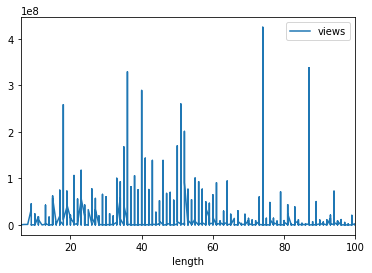

In [40]:
VideoTitleLengthGB.sort_values('length').plot.line(x='length',y='views')

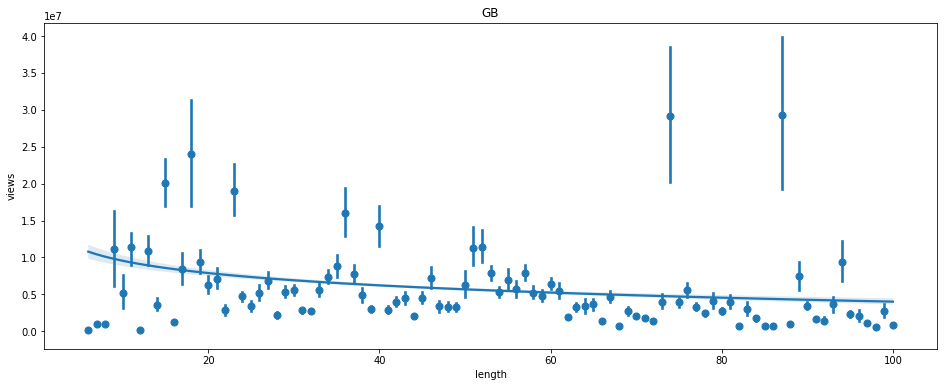

In [41]:
plt.figure(figsize=(16, 6))
ax = sns.regplot(x="length", y="views", data=VideoTitleLengthGB, x_estimator=np.mean, logx=True, truncate=True)
ax.set_title('GB')
plt.show()

In [43]:
# similar to the US data that we took a look at the length of the title does not greatly affect the number of views a trending
# video gets, however there is a slight increase the shorter the title